# Daymet mapping to NHM hrus
This notebook demonstrates the Daymet mapping/interpolating to NHM HRUs

In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json

Populating the interactive namespace from numpy and matplotlib


# Open Daymet max temperature with geopandas and plot

In [2]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../../Data_v1_1') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
# glob below is not necessary in this case as there is only one shapefile.  Will keep
# code this way as in the case of HRUs split into multiple shapefiles this is how to concatenate
# into one geodataframe

shapefiles = folder.glob("*2c*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
#print(gdf)

B:\GitRepos\onhm-fetcher-parser\notebooks\final_notebooks
..\..\Data_v1_1


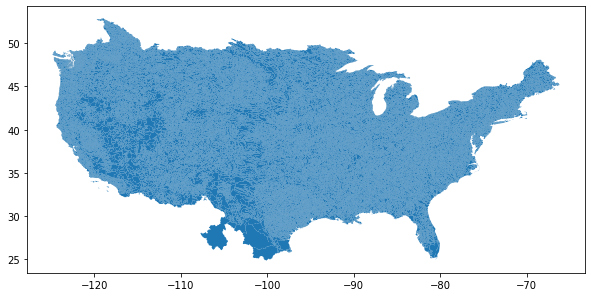

In [3]:
gdf.plot()

# Open Daymet data (as netcdf file) 
https://daymet.ornl.gov/web_services

In [2]:
import requests
from requests.exceptions import HTTPError
from datetime import datetime, timedelta
from urllib.parse import urlencode

prcpurl = 'https://thredds.daac.ornl.gov/thredds/ncss/daymet-v3-agg/na.ncml'
prcppayload = {
#     'var': 'lat&var=lon&var=tmax',
    'var': 'lat&var=lon&var=prcp&var=srad&var=swe&var=tmax&var=tmin&var=vp',
    'north': '54',
    'west': '-126',
    'east': '-65',
    'south': '20',
    'disableProjSubset': 'on',
    'horizStride': '1',
    'time_start': '2018-12-31T12:00:00Z',
    'time_end': '2018-12-31T12:00:00Z',
    'timeStride': '1',
    'accept': 'netcdf'}    
try:
    s = requests.Session()
    #https://github.com/psf/requests/issues/1454
    qry = urlencode(prcppayload).replace('%26','&')
    qry = qry.replace('%3D', '=')
    print(qry)
    tmaxfile = requests.get(prcpurl, params=qry)
    tmaxfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occured: {http_err}')
except Exception as err:
    print(f'Other error occured: {err}')
else:
    print('Daymet data retrieved!')
    
with open('tmax_test2.nc', 'wb') as fh:
    fh.write(tmaxfile.content)
fh.close    

#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
# dirPath='https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_prcp_2018_na.nc4?var=lat&var=lon&var=prcp&north=52.880049298000074+&west=-124.72462483099997+&east=-66.94953853699997+&south=24.839424370000074&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00:00:00Z&time_end=2018-12-31T00:00:00Z&timeStride=1&accept=netcdf'
# fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'
dirPath = 'tmax_test2.nc'
# dirPath = 'daymet_v3_tmax_2018_na.nc4.nc'
#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
fullfilename= dirPath
print(fullfilename)

ds = xr.open_dataset(fullfilename)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', ds.attrs)
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['time']
datahandle=ds['tmax']
dhlat = ds['lat']
dhlon = ds['lon']
crshandle=ds['lambert_conformal_conic']
print('\n The crs meta data is \n', crshandle.attrs)
print(datahandle)


#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n',datahandle.attrs)
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)
print('\n Lat coords are: \n', dhlat.attrs)

ts = datahandle.sizes
print(type(ts))
print(ts['time'])
dayshape = ts['time']
Lonshape = ts['x']
Latshape = ts['y']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)


var=lat&var=lon&var=prcp&var=srad&var=swe&var=tmax&var=tmin&var=vp&north=54&west=-126&east=-65&south=20&disableProjSubset=on&horizStride=1&time_start=2018-12-31T12%3A00%3A00Z&time_end=2018-12-31T12%3A00%3A00Z&timeStride=1&accept=netcdf
Daymet data retrieved!
tmax_test2.nc
<xarray.Dataset>
Dimensions:                  (time: 1, x: 6008, y: 3699)
Coordinates:
  * y                        (y) float32 1687.0 1686.0 ... -2010.0 -2011.0
  * x                        (x) float32 -2754.25 -2753.25 ... 3251.75 3252.75
  * time                     (time) datetime64[ns] 2018-12-31
Data variables:
    lat                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
    lon                      (y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
   

In [4]:
lon = ds.lon.values
numcells = np.shape(lon)[0]*np.shape(lon)[1]
numcells

22223592

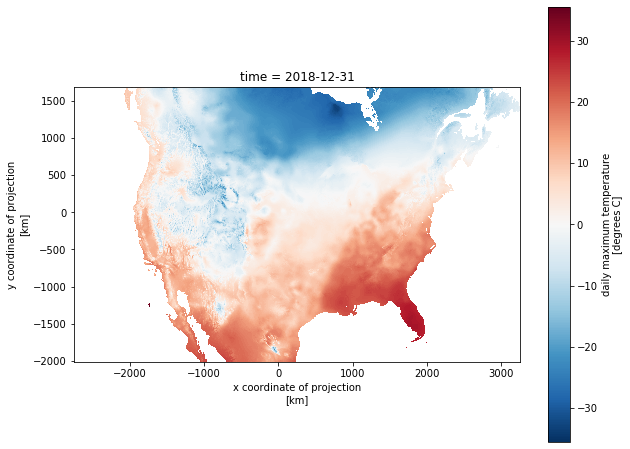

In [16]:
tmax = ds.tmax.isel(time=[0])
# p = tmax.plot(col = 'time', aspect = ds.dims['x']/ds.dims['y'], size = 2)
p = tmax.plot()
p.axes.set_aspect('equal')
plt.show()

In [ ]:
# wght_UofI = pd.read_csv('../pkg/tmp_weights_hru_v1_1.csv')
# print(wght_UofI.head())

# #iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
# ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')

# print(ndata[1000:])

# unique_hru_ids = wght_UofI.groupby('GFv11_id')
# print(len(gdf), len(unique_hru_ids))

In [ ]:
# print(gdf.iloc[0]['GFv11_id'] in unique_hru_ids)

In [ ]:
# # read hru nhm_id that have no intersections
# hru_nointsct = pd.read_csv(r'../Data_v1_1/gridmet_hru_v1_1_nointsct.txt')
# hru_nointsct.head()
# noint = hru_nointsct.hru_nointsct.unique()
# print(type(noint))

   grid_ids  GFv11_id         w
0  11225754     76127  0.005391
1  11218356     76127  0.004948
2  11214657     76127  0.005054
3  11207259     76127  0.005567
4  11203560     76127  0.000181
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
139808 114289
min/max -21.69890163539225 29.500000000000007


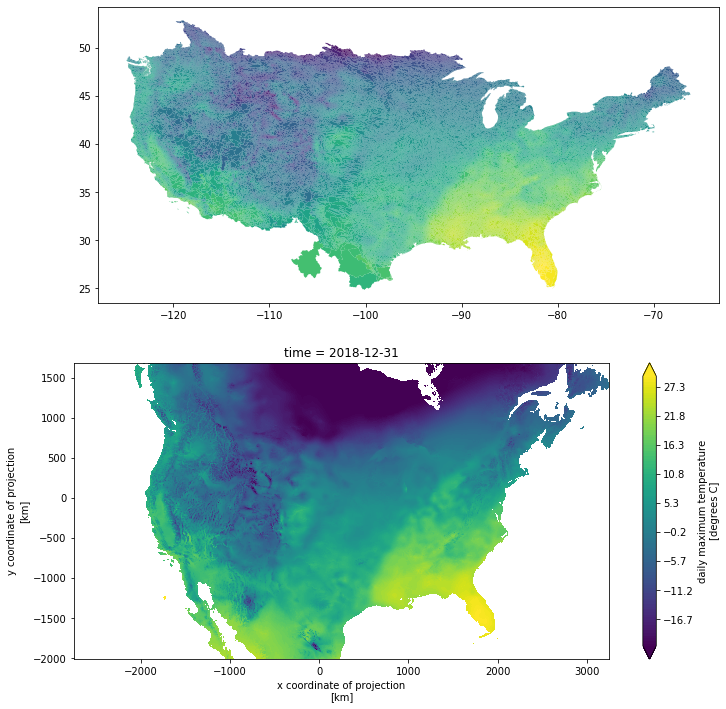

In [20]:
from numpy.ma import masked
# add tmax column to dataframe
gdf['tmax']=0.0
# gdf.tmax[noint] = 10.0
# print(gdf.tmax[noint])

wght_UofI = pd.read_csv('../../Data_v1_1/tmp_weights_daymet2.csv')
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
# ndata = datahandle.values[dayshape-1,:,:].flatten(order='C')
# ndata = ds.tmax.values[dayshape-1,:,:].flatten()
lon = ds.lon.values
lat = ds.lat.values
ndata = np.zeros(np.shape(lon)[1]*np.shape(lon)[0])
tlc = 0
for j in range(np.shape(lon)[1]):
    if j%100 == 0: print(j)
    for i in range(np.shape(lon)[0]):
        ndata[tlc] = datahandle.values[dayshape-1,i,j]
        tlc+=1

# print(ndata[1000:])

unique_hru_ids = wght_UofI.groupby('GFv11_id')
print(len(gdf), len(unique_hru_ids))

def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
def np_get_wval(ndata, wghts, hru_id):
    """
    Returns weighted average of ndata with weights = grp
    1) mdata = the subset of values associated with the gridmet id's that are mapped to hru_id.
    2) Some of these values may have nans if the gridmet id is outside of conus so only return values
    that are inside of conus
    3) this means that hru's that are entirely outside of conus will return nans which will ultimately,
    outside of this function get assigned zero's.
    4) the value is assigned the weighted average
    :param ndata: float array of data values
    :param wghts: float array of weights
    :param hru_id hru id number
    :return: numpy weighted averaged - masked to deal with nans associated with
            ndata that is outside of the conus.
    """
    mdata = np.ma.masked_array(ndata[wghts['grid_ids'].values.astype(int)],
                               np.isnan(ndata[wghts['grid_ids'].values.astype(int)]))

    # mdata = np.ma.masked_where(ndata[wghts['grid_ids'].values.astype(int)] <= 0.0,
    #                            (ndata[wghts['grid_ids'].values.astype(int)]))
    tmp = np.ma.average(mdata, weights=wghts['w'])
    if tmp is masked:
        # print('returning masked value', hru_id, mdata, wghts['w'])
        return np.nan

    else:
        return tmp
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
#     if not(row['nhm_id'] in noint):
    try: 
        weight_id_rows = unique_hru_ids.get_group(row['GFv11_id'])
        td[index] = np.nan_to_num(np_get_wval(ndata, weight_id_rows, index+1))
    except KeyError:
        td[index] = 0.0
            
            
#         gdf['tmax'][index] = np_get_wval2(weight_id_rows, ndata)
#     else:
#         td[index] = 10.0

gdf['tmax'] = td.tolist()
# gdf['tmax'].fillna(0.0)

print('min/max', gdf['tmax'].min(), gdf['tmax'].max())

f, ax = plt.subplots(2, figsize=(12,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white')
ax[0].set_aspect('equal')
ptmax = ds.tmax
ptmax_1 = ptmax.isel(time=dayshape-1)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')

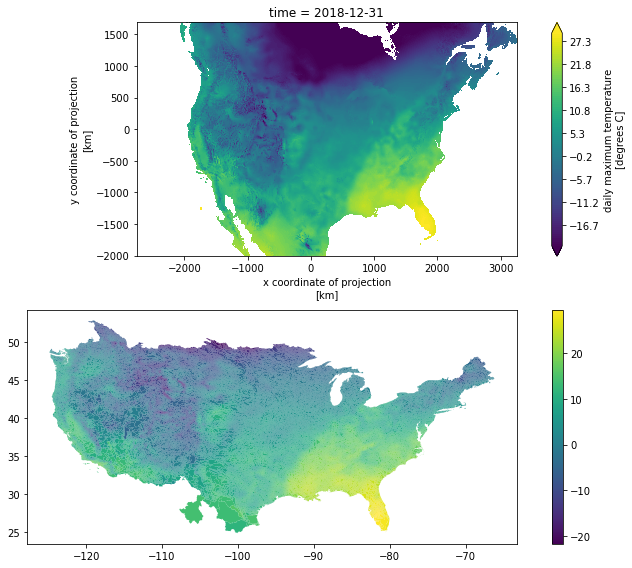

In [22]:
f, ax = plt.subplots(2, 1)

lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)

ptmax = ds.tmax
ptmax_1 = ptmax.isel(time=dayshape-1)
p=ptmax_1.plot(ax=ax[0], levels=lvs, cmap='viridis')
ax[0].set_aspect('equal', 'box')

g = gdf.plot(ax=ax[1], column = 'tmax',linewidth=0., edgecolor='white', legend=True)
# temp = ds.daily_maximum_temperature[0,:,:]-273.5
ax[1].set_aspect('equal', 'box')


plt.tight_layout()
plt.show()

##### lon = ds.lon.values
lat = ds.lat.values
print(np.shape(lon))

In [ ]:
print(unique_hru_ids.head())

print(len(td))
print(len(gdf))
print(gdf.head())
print(td[0])
print(unique_hru_ids.get_group(gdf.iloc[0]['nhm_id']))
print('true or false', gdf.iloc[0]['nhm_id'] in unique_hru_ids)


# Perform zonal stats using rasterstats with the geotiff raster and hru shapefile

In [ ]:
import geoplot as gplt

print(transform)
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)

hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, array, transform=transform.to_gdal(), prefix='tmax_', all_touched=True)
statsdf = pd.DataFrame(stats)
src.close()

print(statsdf.head())

zonalhru = hrudata.join(statsdf)

# # print(stats)
# # newhru = hrudata.join(gpd.DataFrame(stats))
# # print(newhru.head())
zonalhru.__class__ = gpd.GeoDataFrame
zonalhru.crs={}
zonalhru.set_geometry('geometry')
# ax = gplt.pointplot(zonalhru['mean'])
# gplt.polyplot()
# geoplot.choropleth(zonalhru, hue='mean', cmap='viridis', k = 20, 
#                 linewidth=0.5, legend=True)
zonalhru.plot(column='tmax_mean', cmap='viridis')

# Alternative Rasterstats method: 
* https://geohackweek.github.io/vector/06-geopandas-advanced/

In [ ]:
import rasterio
import rasterio.plot as rioplot
import cartopy.crs as ccrs

# print(transform)
with rasterio.open(r'test1.tif') as src:
    transformb = src.meta['transform']
    print(type(transformb), src.meta)
    array = src.read(1)
rasterdata = rasterio.open(r'test1.tif')
tmp = rioplot.show(rasterdata, with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
print(tmp.axis)
tmp.set_xlim([-82, -70])
tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, r'test1.tif', transform=transformb.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True)
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})

# Alternative Rasterstats by opening netcdf directly rather than first saving to geotif

In [ ]:
import rasterio
import rasterio.plot as rioplot
import cartopy.crs as ccrs

print(os.getcwd())
with rasterio.open(r'../Data/new.nc', driver='NetCDF') as src:
    transformb = src.meta['transform']
    print(type(transformb), src.meta)
    array = src.read(1)
rasterdata = rasterio.open(r'test1.tif')
tmp = rioplot.show(rasterdata, with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
print(tmp.axis)
tmp.set_xlim([-82, -70])
tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, r'test1.tif', transform=transformb.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True)
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})

In [ ]:
print(len(stats_gdf.index))

# write netcdf file using netcdf4
* https://github.com/Unidata/netcdf4-python/blob/master/examples/writing_netCDF.ipynb

In [ ]:
import netCDF4
try: ncfile.close() # just to be safe, make sure dataset is not already open.
except: pass
ncfile = netCDF4.Dataset('new.nc',mode='w',format='NETCDF4_CLASSIC')

# Global Attributes
ncfile.Conventions = 'CF-1.8'
ncfile.featureType = 'timeSeries'
ncfile.history = ''

sp_dim = len(stats_gdf.index)
hruid_dim = ncfile.createDimension('hruid', sp_dim)     # hru_id
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

#Create Variables
time = ncfile.createVariable('time', np.int, ('time', ))
time.long_name = 'time'
time.standard_name = 'time'
time.units = 'days since '+'base_date'+' 00:00'+'time_zone'

hru = ncfile.createVariable('hruid', np.int, ('hruid', ))
hru.cf_role = 'timeseries_id'
hru.long_name = 'local model hru id'

lat = ncfile.createVariable('hru_lat', np.float32, ('hruid',))
lat.long_name = 'Latitude of HRU centroid'
lat.units = 'degrees_north'
lat.standard_name = 'hru_latitude'

lon = ncfile.createVariable('hru_lon', np.float32, ('hruid',))
lon.long_name = 'Longitude of HRU centroid'
lon.units = 'degrees_east'
lon.standard_name = 'hru_longitude'

prcp = ncfile.createVariable('prcp', np.float32, ('time', 'hruid'))
prcp.long_name = 'Daily precipitation rate'
prcp.units = 'mm/day'
prcp.standard_name = 'lwe_precipitation_rate'

tmax = ncfile.createVariable('tmax', np.float32, ('time', 'hruid'))
tmax.long_name = 'Maximum daily air temperature'
tmax.units = 'degree_Celsius'
tmax.standard_name = 'maximum_daily_air_temperature'

tmin = ncfile.createVariable('tmin', np.float32, ('time', 'hruid'))
tmin.long_name = 'Minimum daily air temperature'
tmin.units = 'degree_Celsius'
tmin.standard_name = 'minimum_daily_air_temperature'

# fill variables with available data
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = stats_gdf['geometry'].centroid
tlon, tlat = [list(t) for t  in zip(*map(getXY, centroidseries))]
# print(lon, lat)
lon[:] = tlon
lat[:] = tlat
hru[:] = stats_gdf['hru_id_nat'].values
# print(hruid)
tmax[0,:] = stats_gdf['tmax_mean'].values

print(ncfile)
ncfile.close(); print("dataset is closed")
